# Introduction: 

The aim of this project is to identify which factors predict user adoption by defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period


The data is available as two attached CSV files and each data set has the following information:<br>

1.`takehome_users.csv`<br>
A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:<br>
 ● **name:** the user's name <br>
 ● **object_id:** the user's id <br>
 ● **email:** email address <br>
 ● **creation_source**: how their account was created. This takes on one of 5 values:<br>
           ○ **PERSONAL_PROJECTS:** invited to join another user's personal workspace<br>
           ○ **GUEST_INVITE:** invited to an organization as a guest (limited permissions)<br>
           ○ **ORG_INVITE:** invited to an organization (as a full member) <br>
           ○ **SIGNUP:** signed up via the website <br>
           ○ **SIGNUP_GOOGLE_AUTH:** signed up using Google Authentication (using a Google email account for their login id)<br>
 ● **creation_time:** when they created their account <br>
 ● **last_session_creation_time:** unix timestamp of last login <br>
 ● **opted_in_to_mailing_list:** whether they have opted into receiving marketing emails <br>
 ● **enabled_for_marketing_drip:** whether they are on the regular marketing email drip <br>
 ● **org_id:** the organization (group of users) they belong to <br>
 ● **invited_by_user_id:** which user invited them to join (if applicable) <br>
 ● **user_id:** which user invited them to join (if applicable) <br>

2. `takehome_user_engagement.csv`<br>
A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.


In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from collections import Counter
%matplotlib inline

In [2]:
# Load and examine the data 
user_engagement_df= pd.read_csv(r"C:\Users\Bara Elshaer\Documents\Python\Data Science\Relax Challenge\takehome_user_engagement.csv")
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
user_info_df=pd.read_csv(r"C:\Users\Bara Elshaer\Documents\Python\Data Science\Relax Challenge\takehome_users.csv", encoding="latin-1")
user_info_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


**Note:** I had to encode string from UTF-8 to Latin-1 in order to allow proper read of the csv file. 

In [4]:
# Examining the user data to see who is using the application 

'''
I am passing the user engagement table because I want to count all the users who are actually using the application. 
'''
a= len(list(user_engagement_df['user_id'].unique()))
print('Total number of active users of the application:', a)

'''
I am passing the takehome user table because I want to count the total number of people who signed up regardless of 
their activity status.
'''
b= len(list(user_info_df['object_id'].unique()))
print('Total number of users who signed up for the application:', b)

print('Total number of user discrepancy:', b-a)

Total number of active users of the application: 8823
Total number of users who signed up for the application: 12000
Total number of user discrepancy: 3177


I can confirm the math of inactive users (the users who never signed in) by executing the following code block:

In [5]:
print('Total number of inactive users:', 
      len(user_info_df[user_info_df['last_session_creation_time'].isnull()]))

Total number of inactive users: 3177


## Data Wrangling

In [6]:
# Checking for missing data in the user engagement table
print(user_engagement_df.isnull().any())

time_stamp    False
user_id       False
visited       False
dtype: bool


In [7]:
# Checking for missing data in the user information table
print(user_info_df.isnull().any())

object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
dtype: bool


In [8]:
'''
Checking to see how much missing data there is in the last_session_creation_time column and invited_by_user_id column 
'''
print(user_info_df['invited_by_user_id'].isnull().value_counts())

print(user_info_df['last_session_creation_time'].isnull().value_counts())

False    6417
True     5583
Name: invited_by_user_id, dtype: int64
False    8823
True     3177
Name: last_session_creation_time, dtype: int64


There is a significant number of missing values from `invited_by_user_id` and `last_session_creation_time`, which is 5583 and 3177 respectively.

In [9]:
# Change the time stamp in the table to a datetime object 
user_engagement_df['time_stamp'] = pd.to_datetime(user_engagement_df['time_stamp'])

In [10]:
# Creating a for loop with the definition of adopted user to categorize the data

seven_days=datetime.timedelta(7)
adopted= {}

for user_id in sorted(list(user_engagement_df['user_id'].unique())):
    
    adopted_user =  False
    temp= user_engagement_df[user_engagement_df['user_id']== user_id]
    temp= temp.sort_values('time_stamp')
    
    for row in temp.itertuples():
        if adopted_user == True:
            continue 
        this_time= temp.at[row[0], 'time_stamp']
        if len(temp[(temp['time_stamp'] >= this_time) & (temp['time_stamp']<= (this_time + seven_days))]) >= 3:
            
            adopted_user= True
    
    adopted[user_id]= adopted_user

In [11]:
# Calculating the percentage of active users 

count_df= pd.DataFrame.from_dict(Counter(list(adopted.values())), orient='index').reset_index()
unique_users=len(adopted)
print('Total number of unique users:',unique_users)

count_df

Total number of unique users: 8823


,index,0
0,False,7167
1,True,1656


In [12]:
'''
Using the meaning of adopted user, there is a total number of 1656 users who fit the definition
'''
percent=(1656/unique_users)*100
print('Percent of users that fit the definition of adopted-users:',percent)

Percent of users that fit the definition of adopted-users: 18.769126147568855


In [44]:
# Creating a table that displays the status of adopted 
user_info_df['adopted']= False

user_info_df

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,day_created,hour_created
0,GUEST_INVITE,1.398139e+09,1,0,11,False,3,0
1,ORG_INVITE,1.396238e+09,0,0,1,False,3,0
2,ORG_INVITE,1.363735e+09,0,0,94,False,3,0
3,GUEST_INVITE,1.369210e+09,0,0,1,False,3,0
4,GUEST_INVITE,1.358850e+09,0,0,193,False,3,0
5,GUEST_INVITE,1.387424e+09,0,0,197,False,3,0
6,SIGNUP,1.356010e+09,0,1,37,False,3,0
7,PERSONAL_PROJECTS,1.382888e+09,1,1,74,False,3,0
8,PERSONAL_PROJECTS,1.382888e+09,0,0,302,False,3,0
9,ORG_INVITE,1.401833e+09,1,1,318,False,3,0


In [14]:
user_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null bool
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 949.3+ KB


In [15]:
# Checking the defined features
for feature in ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']:
    print('{} feature:'.format(feature))
    print(user_info_df[feature].value_counts(), end='\n\n')

creation_source feature:
ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

opted_in_to_mailing_list feature:
0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

enabled_for_marketing_drip feature:
0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64



In [16]:
user_info_df['last_session_creation_time'] = user_info_df['last_session_creation_time'].fillna(user_info_df['last_session_creation_time'].median())
user_info_df['creation_time'] = pd.to_datetime(user_info_df['last_session_creation_time'])
user_info_df['creation_time'] = pd.to_datetime(user_info_df['creation_time'])

# day of the week account created
user_info_df['day_created'] = user_info_df['creation_time'].apply(lambda x: x.dayofweek)

# hour of the day account created
user_info_df['hour_created'] = user_info_df['creation_time'].apply(lambda x: x.hour)

# drop the original column
user_info_df.drop('creation_time', axis=1, inplace=True)

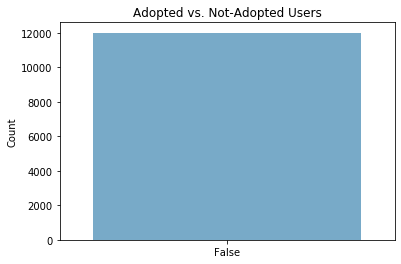

In [45]:
# Bar graph of Adopted Users vs. Not-Adopted Users
sns.barplot(x = list(user_info_df['adopted'].value_counts().index), y = user_info_df['adopted'].value_counts(), palette='Blues')
plt.ylabel('Count')
plt.title('Adopted vs. Not-Adopted Users');

Since there is heavy imbalance in the classes here I will split the data into training and testing data and then oversample the training data to balance out the classes without distorting the testing data.

In [18]:
# Dropping unnessescary columnsand assigning it to a new variable 
user_info_df.drop(['name', 'email', 'invited_by_user_id', 'object_id'], axis=1, inplace=True)


In [19]:
user_info_df.head()

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,day_created,hour_created
0,GUEST_INVITE,1.398139e+09,1,0,11,False,3,0
1,ORG_INVITE,1.396238e+09,0,0,1,False,3,0
2,ORG_INVITE,1.363735e+09,0,0,94,False,3,0
3,GUEST_INVITE,1.369210e+09,0,0,1,False,3,0
4,GUEST_INVITE,1.358850e+09,0,0,193,False,3,0


In [20]:
# Convert categorical variable into dummy/indicator variables

df_convert= pd.get_dummies(user_info_df, columns=['creation_source'])

In [21]:
X= df_convert.drop('adopted', axis=1)
y= df_convert['adopted']

In [46]:
# Split into train and test sets

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.30, random_state=2007, stratify= user_info_df['adopted'])

In [23]:
y_train.head()

81      False
7310    False
7889    False
7514    False
1322    False
Name: adopted, dtype: bool

In [24]:
X_train.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,day_created,hour_created,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
81,1.401848e+09,0,0,91,3,0,1,0,0,0,0
7310,1.359931e+09,0,0,201,3,0,0,1,0,0,0
7889,1.347872e+09,0,0,206,3,0,0,0,0,0,1
7514,1.382888e+09,0,0,53,3,0,0,1,0,0,0
1322,1.382888e+09,0,0,102,3,0,1,0,0,0,0


An imbalanced dataset is a dataset where the number of data points per class differs drastically, resulting in a heavily biased machine learning model that won’t be able to learn the minority class. When this imbalanced ratio is not so heavily skewed toward one class, such dataset is not that horrible, since many machine learning models can handle them. Data oversampling is a technique applied to generate data in such a way that it resembles the underlying distribution of the real data. In this project, I will use an oversampling technique called Synthetic Minority Over-Sampling Technique or SMOTE to balance out our dataset. SMOTE is an oversampling algorithm that relies on the concept of nearest neighbors to create its synthetic data.

In [29]:
import imblearn

In [33]:
# Using SMOTE oversampling to balance out the classes 
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = ADASYN().fit_sample(X_train, y_train)
# X_resampled, y_resampled = X_train, y_train
#ADASYN().fit_sample(X, y)

print(sorted(Counter(y_resampled).items()))


ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [34]:
np.unique(y)

array([False])